Basis Pursuit DeNoising (Accelerated PGM)
=========================================

This example demonstrates the use of class
[pgm.AcceleratedPGM](../_autosummary/scico.optimize.rst#scico.optimize.AcceleratedPGM)
to solve the sparse coding problem problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - D \mathbf{x} \|_2^2
  + \lambda \| \mathbf{x} \|_1\;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented,
and $\mathbf{x}$ is the sparse representation.

In [1]:
import numpy as np

import jax

from scico import functional, linop, loss, plot
from scico.optimize.pgm import AcceleratedPGM
from scico.util import device_info
plot.config_notebook_plotting()

Construct a random dictionary, a reference random sparse
representation, and a test signal consisting of the synthesis of the
reference sparse representation.

In [2]:
m = 512  # Signal size
n = 4 * m  # Dictionary size
s = 32  # Sparsity level (number of non-zeros)
σ = 0.5  # Noise level

np.random.seed(12345)
D = np.random.randn(m, n)
L0 = np.linalg.norm(D, 2) ** 2

x_gt = np.zeros(n)  # true signal
idx = np.random.permutation(list(range(0, n - 1)))
x_gt[idx[0:s]] = np.random.randn(s)
y = D @ x_gt + σ * np.random.randn(m)  # synthetic signal

x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU
y = jax.device_put(y)  # convert to jax array, push to GPU

Set up the forward operator and AcceleratedPGM solver object.

In [3]:
maxiter = 100
λ = 2.98e1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g = λ * functional.L1Norm()
solver = AcceleratedPGM(
    f=f, g=g, L0=L0, x0=A.adj(y), maxiter=maxiter, itstat_options={"display": True, "period": 10}
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  9.71e-01  7.795e+09  4.611e+03  4.126e+03


  10  1.82e+00  1.211e+06  4.611e+03  1.369e+01
  20  1.84e+00  2.102e+04  4.611e+03  1.476e+00
  30  1.87e+00  2.126e+03  4.611e+03  3.078e-01
  40  1.89e+00  8.819e+02  4.611e+03  9.747e-02
  50  1.91e+00  8.306e+02  4.611e+03  2.501e-02
  60  1.94e+00  8.240e+02  4.611e+03  1.229e-02
  70  1.96e+00  8.201e+02  4.611e+03  6.280e-03
  80  1.98e+00  8.197e+02  4.611e+03  2.978e-03
  90  2.00e+00  8.195e+02  4.611e+03  1.815e-03


  99  2.02e+00  8.195e+02  4.611e+03  1.059e-03


Plot the recovered coefficients and convergence statistics.

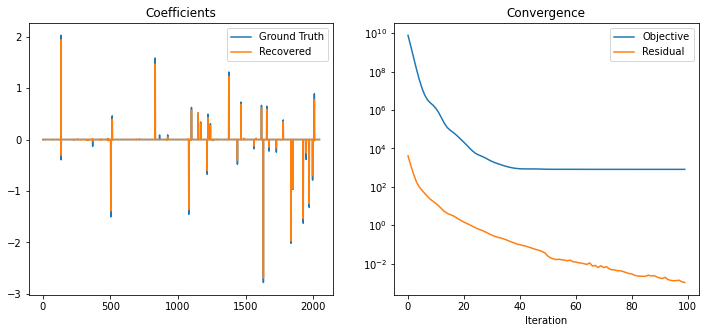

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((x_gt, x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((hist.Objective, hist.Residual)).T,
    ptyp="semilogy",
    title="Convergence",
    xlbl="Iteration",
    lgnd=("Objective", "Residual"),
    fig=fig,
    ax=ax[1],
)
fig.show()